In [98]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import gender_guesser.detector as gender
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

#### Raspagem: lista de mulheres nomeadas e ganhadoras do Oscar em categorias em que gêneros competem.

**Obs.: Essa foi uma raspagem inicial de uma página da Wikipedia. No projeto final, a fonte usada foi a base de dados do Oscar mostrada mais abaixo.**

Como alguns elementos ocupam mais que uma linha, não é possível fazer a raspagem iterando entre os múltiplos de cada célula. A solução encontrada foi:

- Para o ano ('year'): tentar converter os 4 primeiros caracteres da célula em inteiro. Se não houver erro, é porque a célula é um ano válido; ele é salvo na variável `new_year`.
- Para o status ('Nominated' ou 'Won'): todas as células de status possuem `<td class="no table-no2" (...)>` para _Nominated_ ou `<td class="yes table-yes2" (...)>` para _Won_. Verifica-se se a célula atual é uma dessas e, se sim, o texto dela, da categoria (título da tabela) e do ano `new_year` é adicionado em suas respectivas listas.


In [99]:
url = "https://en.wikipedia.org/wiki/List_of_female_Academy_Award_winners_and_nominees_for_non-gendered_categories"
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')

year = []
category = []
status = []
all_tables = soup.find_all(class_='wikitable')

for table in all_tables:
	td = table.find_all('td')
	new_year = 0
	for i in range(0, len(td)):
		try:
			old_year = new_year
			new_year = int(td[i].text[0:4])
			if new_year < 1000:
				new_year = old_year
		except ValueError:
			pass
		if td[i].get('class'):
			status.append(td[i].text[0:-1])
			category.append(td[0].text[18:-1])
			if new_year != 0:
				year.append(new_year)

oscar_women_df = pd.DataFrame({
	'year': year,
	'category': category,
	'status': status
})

#	renomeia as categorias que possuíam sobrescrito no título.
oscar_women_df.category = oscar_women_df.category.replace({
	'Best Sound [note 12]': 'Best Sound Mixing',
	'Best Original Score [note 7]': 'Best Original Score'
})

#	corrige um typo na tabela original.
oscar_women_df.status = oscar_women_df.status.replace({'Nominated}': 'Nominated'})


# Raspagem: [base de dados da Academia de Artes e Ciências Cinematográficas](https://awardsdatabase.oscars.org/).
Devido à dinamicidade do site, para a automação completa seria necessária o uso do Selenium. Para os fins do projeto, o código da página de busca avançada foi salvo nos arquivos `nominees-men.html` e `nominees-women.html`. As páginas possuem as seguintes categorias:

**Páginas salvas:**
1. Best Picture
2. Directing
3. Writing
4. Cinematography
5. Costume Design
6. Documentary Feature
7. Short Film (live action)
8. Film Editing
9. Makeup

Obs.: Quando alguém é indicado por dois filmes no mesmo ano, somente o primeiro filme é minerado (e terminado por ';'). Como a análise é focada na pessoa nomeada e não no filme, essa questão não foi tratada.

In [91]:
# Cria o dataframe para páginas de buscas com múltiplas categorias.
def get_oscar_df(file):
	f = open(file)
	soup = BeautifulSoup(f, 'html.parser')
	df = pd.DataFrame({'year': [], 'category': [], 'film': [], 'name': [], 'status': []})

	all_groups = soup.find_all(class_='awards-result-chron result-group group-awardcategory-chron')
	for group in all_groups:
		year = group.find(class_="result-group-title").text.strip()[0:4]
		all_categories = group.find_all(class_="result-subgroup subgroup-awardcategory-chron")
		for each_category in all_categories:
			category = each_category.find(class_="result-subgroup-title").text.strip()

			if category.split()[0] == 'SHORT':
				all_films = each_category.find_all(class_="result-details awards-result-other")
			else:
				all_films = each_category.find_all(class_="result-details awards-result-actingorsimilar")
			for row in all_films:
				try:
					film = row.find(class_="awards-result-film-title").text.strip()
				except AttributeError:
					film = 'Error'
				if row.find(class_="glyphicon glyphicon-star"):
					status = 'winner'
				else:
					status = 'nominated'
				all_names = re.split(r'; |: | and | & | by |, ', row.find(class_="awards-result-nominationstatement").text)
				for name in all_names:
					name = name.strip(' \n()')
					row = pd.DataFrame({'year': [year],
										'category': [category],
										'film': [film],
										'name': [name],
										'status': [status]
										})
					df = pd.concat([df, row], ignore_index=True)

	to_remove = ['Jr.', 'Producer', 'Producers', 'Adaptation', 'Art Direction',
				 'Interior Decoration', 'Set Decoration', 'Production Design',
				 'Screenplay', 'Written', 'Story', 'Stories',
				 'Adapted for the screen', 'Written for the screen']
	df = df[df.film != 'Error']
	df = df[-df.name.isin(to_remove)]
	f.close()
	return df

# padroniza os nomes das categorias
def clean_categories(df):
	for row in df.category:
		words = row.split()
		if words[0] == 'DIRECTING':
			df.category = df.category.replace({row: 'DIRECTING'})
		elif words[0] == 'WRITING':
			df.category = df.category.replace({row: 'WRITING'})
		elif words[0] == 'ART':
			df.category = df.category.replace({row: 'ART DIRECTION'})
		elif words[0] == 'CINEMATOGRAPHY':
			df.category = df.category.replace({row: 'CINEMATOGRAPHY'})
		elif words[0] == 'COSTUME':
			df.category = df.category.replace({row: 'COSTUME DESIGN'})
		elif words[0] == 'SPECIAL':
			df.category = df.category.replace({row: 'VISUAL EFFECTS'})
		elif words[0] == 'SOUND':
			df.category = df.category.replace({row: 'SOUND'})
		elif words[0] == 'SHORT':
			df.category = df.category.replace({row: 'SHORT FILM'})
		elif words[1] == 'MOTION':
			df.category = df.category.replace({row: 'BEST PICTURE'})
	return df


In [92]:
# salva para csv:
# women_df = get_oscar_df('oscar-pages/nominees-women.html')
# men_df = get_oscar_df('oscar-pages/nominees-men.html')
# women_df.to_csv('oscar-women-v0.csv', index=False)
# men_df.to_csv('oscar-men-v0.csv', index=False)


#### Limpando os datasets.
Para categorias em que homens e mulheres eram indicados pelo mesmo filme, os indicados apareciam tanto na busca por homens quanto por mulheres. escolheu-se então usar o pacote [`gender-guesser`](https://pypi.org/project/gender-guesser/) para limpar os nomes masculinos da tabela feminina e vice-versa.

Por esse método, 379 mulheres foram removidas do dataset masculino, e 501 homens do dataset feminino. Alguns nomes foram indicados mais de uma vez, então a alteração no tamanho dos datasets foi maior.

In [93]:
women_df = pd.read_csv('oscar-women-v0.csv')
men_df = pd.read_csv('oscar-men-v0.csv')

g = gender.Detector()

female_names = []
male_names = []

for name in women_df.name.unique():
	first_name = name.split()[0]
	if g.get_gender(first_name) == 'male' or g.get_gender(first_name) == 'mostly_male':
		male_names.append(name)
women_df = women_df[-women_df.name.isin(male_names)]

for name in men_df.name.unique():
	first_name = name.split()[0]
	if g.get_gender(first_name) == 'female' or g.get_gender(first_name) == 'mostly_female':
		female_names.append(name)
men_df = men_df[-men_df.name.isin(female_names)]

# converte anos para int
women_df.year.astype(int)
men_df.year.astype(int)

print("Qntd. de nomes femininos removidos: %d" % len(female_names))
print("Qntd. de nomes masculinos removidos: %d" % len(male_names))

# padroniza as categorias:
men_df = clean_categories(men_df)
women_df = clean_categories(women_df)

Qntd. de nomes femininos removidos: 345
Qntd. de nomes masculinos removidos: 442


In [94]:
# salva os datasets tratados em um csv
# women_df.to_csv('oscar-women-v1.csv', index=False)
# men_df.to_csv('oscar-men-v1.csv', index=False)

In [95]:
# adiciona a coluna gender em cada um
women_df['gender'] = 'female'
men_df['gender'] = 'male'

# une os datasets e coloca-o em ordem cronológica
oscar_df = pd.concat([women_df, men_df])
oscar_df = oscar_df.sort_values(by='year')

# salva em um dataset final
oscar_df.to_csv('oscar_dataset.csv', index=False)


# Visualização dos dados


In [96]:
women_df = pd.read_csv('oscar-women-v1.csv')
men_df = pd.read_csv('oscar-men-v1.csv')
oscar_df = pd.read_csv('oscar_dataset.csv')

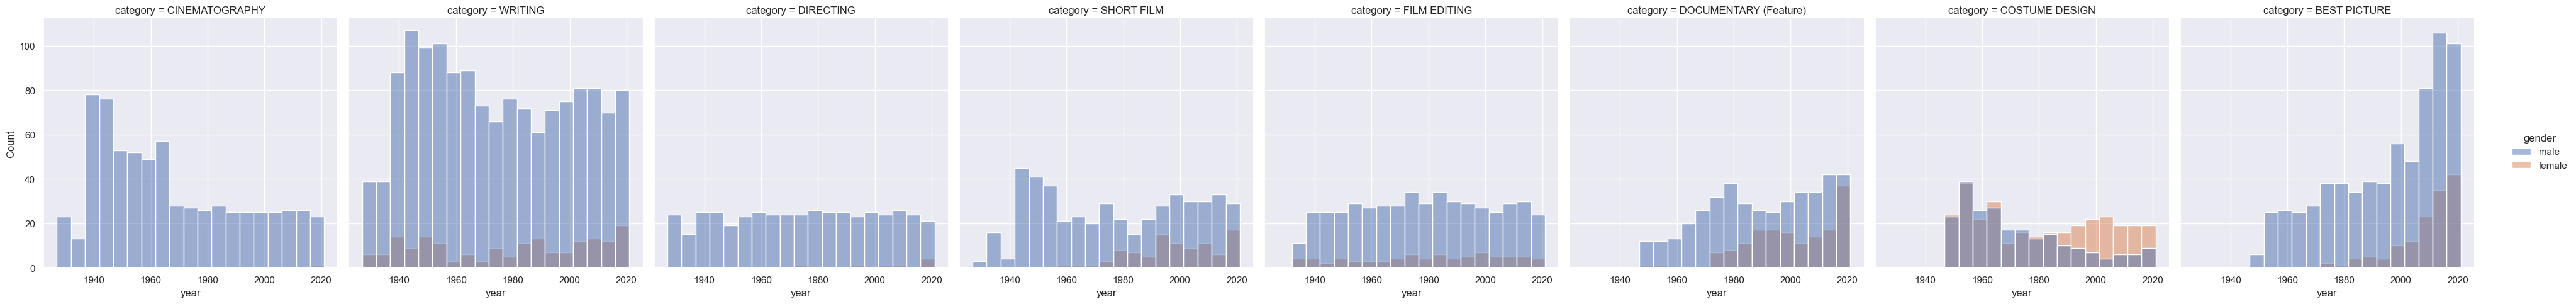

In [100]:
# TESTE
g = sns.displot(data=oscar_df, x='year', hue='gender', col='category', )
# g.savefig('images/categories.png', dpi = 200)
# g.set_xticklabels(step=10)

#### A FAZER:
- ~[X] pegar código fonte do oscar. Dessa vez sem Production design (categoria recente) e sem Filme estrangeiro (não colocam nome dos diretores). Talvez colocar outras categorias.~
- [ ] entender melhor o displot
- [ ] conseguir colocar mais uma cor nos gráficos para ganhadores tanto homens quanto mulheres
- [ ] pensar melhor nas análises que podem ser feitas

#### Gráficos a fazer:
- [ ] Qntd. de homens e mulheres indicados e ganhadores por ano.
- [ ] Qntd. de homens e mulheres indicados e ganhadores em cada categoria.
